There is a file with orders in different restaurants. 

Fields:
* OId - restaurant id,
* OrderId - order id,
* ActivationType - type of user authorization in the order (for example, by table number or phone number), 
* LoginEntryId - user id,
* RegistrationTime - order time

Percentage of cheque penetration by table number - percentage of orders with ActivationType = 14 in a particular organization in relation to all orders in this organization.

What you need to do:

**1. Segment restaurants by percentage of cheque penetration into the table.**

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.cluster import KMeans

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def cum_result(data: 'DataFrame') -> 'DataFrame':
    '''Return cummulative penetration and difference in days per organization'''

    data['Penetration'] = 0
    data['DaysDiff'] = 0
    start_date = data['RegistrationTime'].iloc[0]
    aT = 0
    for i in range(len(data)):
        if data['ActivationType'].iloc[i] == 14:
            aT += 1
            data['Penetration'].iloc[i] = aT / (i + 1)
            data['DaysDiff'].iloc[i] = (data['RegistrationTime'].iloc[i] -
                                        start_date
                                        ).days
        else:
            data['Penetration'].iloc[i] = aT / (i + 1)
            data['DaysDiff'].iloc[i] = (data['RegistrationTime'].iloc[i] -
                                        start_date
                                        ).days

    return data


def min_days(data: 'DataFrame') -> 'DataFrame':
    '''Return number of days required by the restaurant 
        to reach the required penetration'''

    return data[['OId',
                 'RegistrationTime',
                 'Penetration',
                 'DaysDiff']][(data['Penetration'] >= 0.2)].iloc[0]

In [3]:
train = pd.read_csv('data/orders.csv')

In [4]:
train.head(10)

,OId,OrderId,ActivationType,LoginEntryId,RegistrationTime
0,f1965959-0dc2-4fcd-7e59-08d70f880a25,00006919-4979-4960-bc49-08d71c13cd44,-1,NaN,2019-08-12 12:21:43
1,83a1326c-6279-462e-afe0-08d7143c5247,0000ee0d-fe91-4346-a5dc-494cc97fb24f,-1,NaN,2019-08-11 17:46:37
2,3f553a92-116f-11e4-8bac-50465d4d1d14,0000f4ab-777c-4d2f-81fb-e46b2376b23b,-1,NaN,2019-08-11 17:36:52
3,2fbe9269-6093-4a35-16ba-08d6f0cec8aa,0001c73a-99d4-40c5-84f7-cf1562ac7fea,-1,NaN,2019-08-12 07:51:11
4,cd15b0dd-f05e-e611-80ea-0050560102b9,00034022-282c-4b1d-a5d6-4d34c36ce577,-1,NaN,2019-08-12 11:31:47
5,71909a72-7f73-47c8-8583-08d701318257,0004e804-baea-4c89-bfcd-a0ef62510fb0,-1,NaN,2019-08-11 19:47:56
6,3c41a49c-c1ef-4bd7-54b9-08d6f0d11f0c,00054521-e1b8-4d12-9bf2-27e2b238280a,-1,NaN,2019-08-12 17:42:30
7,3d93924f-8915-e911-9667-005056110fc8,000558d6-387f-499f-3ca3-08d71c164c6b,10,9e464ffa-bd39-e911-a2c3-005056111137,2019-08-12 09:54:07
8,0bea41e4-0e47-4b47-8df9-08d710320b23,0005bf1e-8ac3-4db4-9af6-226dfdff47fb,-1,NaN,2019-08-11 20:25:54
9,b56919d9-252f-4dc7-1273-08d6fa3e5beb,0005d181-5be2-40b3-b24b-5268a6142622,-1,NaN,2019-08-12 07:41:07


Let's make a data frame, where each organization will have a sign of "Penitration" - the percentage of penetration of the cheque by table number.  

In [5]:
df = pd.DataFrame(
    pd.merge(
        pd.DataFrame(
            train.
            groupby(['OId'])['OId'].
            count()).
        rename(columns={'OId': 'count'}).
        reset_index(),
        pd.DataFrame(
            train[train['ActivationType'] == 14].
            groupby(['OId'])['OId'].
            count()).
        rename(columns={'OId': 'count'}).
        reset_index(),
        how='left',
        on='OId')
    .fillna(0))

df['penitration'] = df['count_y'] / df['count_x']
df.drop(columns=['count_x', 'count_y'], inplace=True)

In [6]:
df.head(10)

,OId,penitration
0,004b67c3-61ba-498c-c711-08d6df94ce0d,0.00000
1,00ebc9c4-d3ca-e811-a2bb-00505611096a,0.00000
2,01dc42db-102d-4589-54c2-08d6f9ae6921,0.00000
3,02857a80-20c2-e811-a2ba-005056110660,0.00000
4,041e13eb-bb7d-4b2b-75b9-08d70131826f,0.00000
5,050c3bf1-afe7-e611-80f3-0050560102b9,0.06192
6,0528c67e-74d0-e811-a2bc-00505611096a,0.00000
7,08265756-8c5e-e811-a2b8-00505611096a,0.00000
8,0848d65b-840f-11e3-8bac-50465d4d1d14,0.00000
9,094a2346-f5a8-4e5e-80e2-08d6da403bdc,0.00000


Let's segmentation restaurants by percentage of checks penetration into the table using K-Means clustering algorithm. 

We do not know the number of clusters required in advance, so we will use the following criterion - the sum of squares of distances from the points to the centroids of the clusters to which they belong.

In [7]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df[['penitration']])
    inertia.append(np.sqrt(kmeans.inertia_))

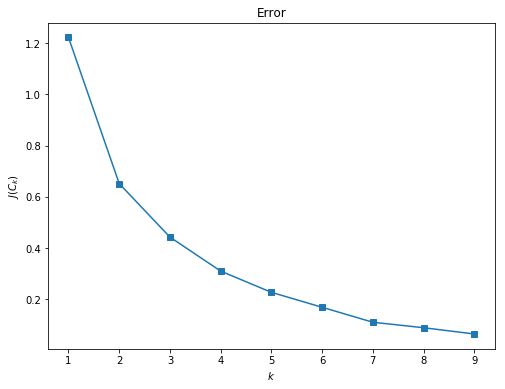

In [8]:
plt.figure(figsize=(8,6))
plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.title('Error');

We can see that the criterion drops strongly when the number of clusters increases from 1 to 2 and from 2 to 3, and not so much when k changes from 3 to 4. It means that in this task it is optimal to specify 3 clusters. 

We could try another number of clusters, because we do not have an obvious "elbow" - the point where the curve becomes steeper. But with more clusters, our first cluster, which stands out in the figure below, will be split into smaller clusters. 

In [9]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df[['penitration']]);

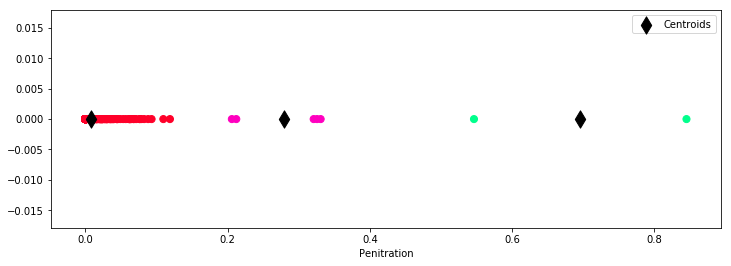

In [10]:
plt.figure(figsize=(12, 4))
plt.scatter(df['penitration'],
            np.zeros(len(df['penitration'])),
            c=kmeans.labels_, s=50, cmap='gist_rainbow')
plt.scatter(kmeans.cluster_centers_,
            np.zeros(len(kmeans.cluster_centers_)),
            marker='d', c='k', s=150, label='Centroids')
plt.xlabel('Penitration')
plt.legend()

And let's add to our data frame a feature that will indicate the number of the cluster to which the restaurant belongs. 

In [11]:
df['Cluster'] = kmeans.labels_

In [12]:
df.sample(n=10)

,OId,penitration,Cluster
194,7cbeb0f6-8c81-e611-80ea-0050560102b9,0.053360,0
75,36bfc569-3291-e611-80fa-005056010fa5,0.000000,0
256,a10abc2a-a373-e711-8112-005056010fa5,0.067873,0
345,d8796384-33ff-40b9-2816-08d6df94c6ec,0.000000,0
258,a374aeae-a64b-4827-c90b-08d6bad3792c,0.000000,0
103,48fb0597-9ae0-453f-606e-08d70f880a2f,0.000000,0
13,0c5e8bec-7136-e911-a2c5-00505611114a,0.000000,0
21,1114ec19-ac5d-4092-c496-08d7013182ad,0.000000,0
110,4b67c79f-ec4b-4f35-3f2a-08d6ca0fa815,0.000000,0
331,d0e1d1d5-53ea-4956-9b4e-08d6e43e3f83,0.000000,0


**2. Calculate the number of days a restaurant can reach the percentage of cheque penetration into the table at 20% (i.e. at first it was less, then it became more or equal to 20%)**

Let's choose a restaurant with a cheque penetration rate >= 20%

In [13]:
penetration_list = list(df[df['penitration'] >= 0.2]['OId'])

Let's leave only those entries in the data frame, where the restaurant ID is in our list of penetration_list

In [14]:
df2 = train[train['OId'].apply(lambda OId: OId in penetration_list)][[
    'OId', 'ActivationType', 'RegistrationTime']]

df2.sort_values(['OId', 'RegistrationTime'], inplace=True)
df2.reset_index(drop='index', inplace=True)

df2['RegistrationTime'] = df2['RegistrationTime'].apply(lambda x:
                                                        datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

Let's apply the cum_result function, which will add some features to the data interface:
1. Penetration - percentage of cheque penetration into the table at the moment
2. Number of days from the first event at the restaurant to the current moment

In [15]:
df2 = df2.groupby(['OId']).apply(cum_result)

In [16]:
df2.head(10)

,OId,ActivationType,RegistrationTime,Penetration,DaysDiff
0,26bd3a99-7f33-e911-a2c4-00505611114a,-1,2019-08-11 23:32:30,0.000000,0
1,26bd3a99-7f33-e911-a2c4-00505611114a,-1,2019-08-11 23:34:11,0.000000,0
2,26bd3a99-7f33-e911-a2c4-00505611114a,-1,2019-08-12 11:49:25,0.000000,0
3,26bd3a99-7f33-e911-a2c4-00505611114a,-1,2019-08-12 11:51:07,0.000000,0
4,26bd3a99-7f33-e911-a2c4-00505611114a,14,2019-08-12 11:58:52,0.200000,0
5,26bd3a99-7f33-e911-a2c4-00505611114a,14,2019-08-12 12:28:23,0.333333,0
6,26bd3a99-7f33-e911-a2c4-00505611114a,14,2019-08-12 12:32:22,0.428571,0
7,26bd3a99-7f33-e911-a2c4-00505611114a,14,2019-08-12 12:34:42,0.500000,0
8,26bd3a99-7f33-e911-a2c4-00505611114a,-1,2019-08-12 12:35:47,0.444444,0
9,26bd3a99-7f33-e911-a2c4-00505611114a,14,2019-08-12 12:39:29,0.500000,0


Сгруппируем данные по ID ресторана и применим функцию min_days, которая выведет количество дней, которое потребовалось каждому ретсорану чтобы достичь процента проникновения чекина в стол в 20%

In [17]:
df2 = df2.groupby(['OId']).apply(min_days).reset_index(drop='index')
df2

,OId,RegistrationTime,Penetration,DaysDiff
0,26bd3a99-7f33-e911-a2c4-00505611114a,2019-08-12 11:58:52,0.200000,0
1,6c0bfd67-99c8-e811-a2b9-00505611096c,2019-08-12 12:21:09,0.214286,0
2,6dcdf611-35ad-e811-a2b8-005056110660,2019-08-12 09:14:36,0.250000,0
3,a1422d5d-7924-e911-9668-00505611117e,2019-08-13 13:50:13,0.200000,1
4,e3c730a4-2184-e711-8112-005056010fa5,2019-08-12 12:58:39,0.222222,0
5,e84ac806-e548-443a-a35b-d407454bfc0c,2019-08-12 13:21:59,0.200980,1
6,f164a99d-be47-462e-9259-1712ce6bb569,2019-08-12 13:15:09,0.205882,1


Также мы можем посчитать среднее количетво дней, которое потребовалось каждому ретсорану чтобы достичь процента проникновения чекина в стол в 20%

In [18]:
round(df2['DaysDiff'].mean(), 2)

0.43